# DATA 102 Final Project (Spring 2021)

**Authors:**
* Jessica Wu
* Christine Chow
* Claudea Jennefer 
* Ellsa Fiorenza 

## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

## Import and Read Datasets

In [6]:
# Census Dataset
census2011 = pd.read_csv("2011 Census.csv")
census2012 = pd.read_csv("2012 Census.csv")
census2013 = pd.read_csv("2013 Census.csv")
census2014 = pd.read_csv("2014 Census.csv")

# Ozone Dataset
ozone = pd.read_csv("OzoneCA.csv", index_col = False, names = ['year', 'date', 'statefips', 'countyfips', 'ctfips', 'latitude, longitude', 'o3 pred', 'o3 std'])

# Location Dataset
stations = pd.read_csv("CAstations.csv")
fips  = pd.read_csv("fips.csv")[73:].reset_index().drop(columns = {'index'})

#COVID19 Dataset
us_counties_covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

#Weather Dataset
weatherCA2020 = pd.read_csv("2020Weather.csv")
weatherCA2021 = pd.read_csv("2021Weather.csv")

#Pollution Dataset
ozone_2020 = pd.read_csv("Ozone2020.csv")
ozone_2021 = pd.read_csv("Ozone2021.csv")
pm25_2020 = pd.read_csv("PM2020.csv")
pm25_2021 = pd.read_csv("PM2021.csv")

## Research Questions

1. **Prediction:** Given the census dataset, what is the predicted value of the ozone concentration?
2. **Instrumental Variable:** Is there a causal relationship between COVID-19 pandemic and pollution (PM2.5) levels?

## Question 1. Prediction

### Data Cleaning

In [ ]:
#Cleaning Census Data
def clean_census(data): 
    #select vehicle
    vehicle = np.array(data.columns[data.iloc[0, :].str.contains("vehicle")])
    
    #select housing fuel 
    fuel = np.array(data.columns[data.iloc[0, :].str.contains("HOUSE HEATING FUEL")])
    all = np.concatenate((["GEO_ID", "NAME"], vehicle, fuel))
    new = data[all]

    #get rid of Margin of Error columns 
    errors = np.array(new.columns[new.iloc[0, :].str.contains("Margin")])
    new = new.drop(axis = 1, columns = errors)
    
    #clean column titles
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.lstrip('Occupied housing units!!'))
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.lstrip('Renter-occupied housing units!!'))
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.lstrip('Owner-occupied housing units!!'))
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.replace('!!VEHICLES AVAILABLE!!', ' '))
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.replace('!!HOUSE HEATING FUEL!!', ' '))
    new.iloc[0, :] = new.iloc[0, :].map(lambda x: x.replace('Estimate', ' '))

    #Drop missing values 
    new.columns = new.iloc[0, :]
    new = new[~(new == 'N').any(axis=1)]
    new.iloc[1:,2:] = new.iloc[1:,2:].astype(float)

    #add columns across different housing units
    grouped = new.iloc[1:,2:].groupby(new.iloc[1:,2:].columns, axis=1).sum()
    new = pd.concat([new.iloc[:,:2], grouped], axis = 1)
    
    # filter to only California
    new  = new.iloc[1:, 1:]
    location = new["Geographic Area Name"].str.split(",", expand = True).rename(columns = {0: "County", 1: "State"})
    new = pd.concat([new.drop(axis = 1, columns = "Geographic Area Name"), location], axis = 1)
    new['State'] = new['State'].str.strip()
    CA = new.loc[new['State'] == 'California']
    return CA

census2011 = clean_census(census2011)
census2012 = clean_census(census2012)
census2013 = clean_census(census2013)
census2014 = clean_census(census2014)

In [ ]:
# Cleaning FIPS Data
def clean_fips(data):
    df = data.rename(columns = {"Federal Information Processing System (FIPS) Codes for States and Counties": 'body'})
    df['fips'] = df["body"].str.split(" ", expand = True)[0].astype(int)
    df['county'] = df["body"].str.extract('([a-zA-Z].*)')[0]
    df = df.drop(columns = {'body'})
    return df

fips = clean_fips(fips) 

In [ ]:
# Clean Ozone dataset

from datetime import datetime
import pandas as pd 

def clean_pollution(data):

    #Created columns for date and month (year already there) because date column was string but not nice to do groupby or something with later on
    data['day'] = [x[0:1] for x in data['date']]
    data['month'] = [x[2:5] for x in data['date']]
    dictionary = {"JAN": 1, "FEB": 2, "MAR":3, "APR":4, "MAY":5, "JUN":6, "JUL":7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12} 
    for key in dictionary.keys():
        data['month'] = data['month'].replace(key, dictionary[key])
    return data.drop(columns=['date'])

ozone = clean_pollution(ozone)

In [ ]:
# merge ozone with FIPS
Ozone_merged = ozone.merge(fips, left_on = 'countyfips', right_on = 'fips')[['month', 'day', 'year', 'o3 pred', 'county']]
Ozone = Ozone_merged.groupby(['county', 'year', 'month'], as_index=False).mean()

In [ ]:
# Merging Ozone with census data
census2011_Ozone = census2011.merge(Ozone.loc[Ozone['year'] == 2011], left_on = 'County', right_on = 'county').drop(columns = {'county'})
census2012_Ozone = census2012.merge(Ozone.loc[Ozone['year'] == 2012], left_on = 'County', right_on = 'county').drop(columns = {'county'})
census2013_Ozone = census2013.merge(Ozone.loc[Ozone['year'] == 2013], left_on = 'County', right_on = 'county').drop(columns = {'county'})
census2014_Ozone = census2014.merge(Ozone.loc[Ozone['year'] == 2014], left_on = 'County', right_on = 'county').drop(columns = {'county'})
census_ozone = pd.concat([census2011_Ozone, census2012_Ozone, census2013_Ozone, census2014_Ozone])

In [ ]:
# removing extra spaces in the column name
census_ozone.columns = pd.Series(census_ozone.columns).str.strip()

### EDA

Distribution of people who have `1 vehicle` only from `2011` until `2014`.

In [ ]:
vehicle1 = [sum(census_ozone[census_ozone['year'] == y]['1 vehicle available']) for y in census_ozone['year'].unique()]
vehicle2 = [sum(census_ozone[census_ozone['year'] == y]['2 vehicles available']) for y in census_ozone['year'].unique()]
vehicle3 = [sum(census_ozone[census_ozone['year'] == y]['3 or more vehicles available']) for y in census_ozone['year'].unique()]
no_vehicle = [sum(census_ozone[census_ozone['year'] == y]['No vehicle available']) for y in census_ozone['year'].unique()]
no_fuel = [np.mean(census_ozone[census_ozone['year'] == y]['No fuel used']) for y in census_ozone['year'].unique()]
fuel_vehicle = [np.mean(census_ozone[census_ozone['year'] == y]['Fuel oil, kerosene, etc.']) for y in census_ozone['year'].unique()]

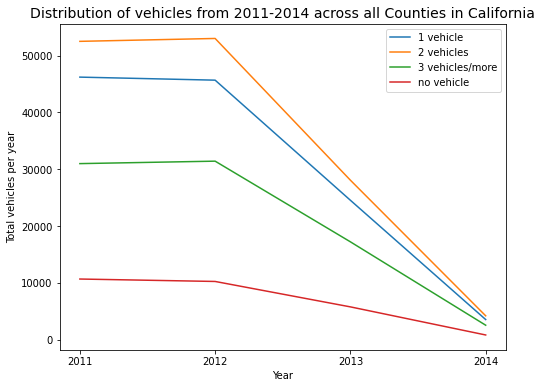

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(census_ozone['year'].unique(), vehicle1, label = "1 vehicle")
plt.plot(census_ozone['year'].unique(), vehicle2, label = "2 vehicles")
plt.plot(census_ozone['year'].unique(), vehicle3, label = "3 vehicles/more")
plt.plot(census_ozone['year'].unique(), no_vehicle, label = "no vehicle")
plt.xticks([2011, 2012, 2013, 2014])
plt.title('Distribution of vehicles from 2011-2014 across all Counties in California', size = 14)
plt.xlabel('Year')
plt.ylabel('Total vehicles per year')
plt.legend()
plt.show()

On average, the total number of people having vehicle decreases from 2011-2014. However, the number of people having 2 vehicles and 3 vehicles or more increases from 2011-2012. The number of people having no vehicle also decreases from 2011-2014.

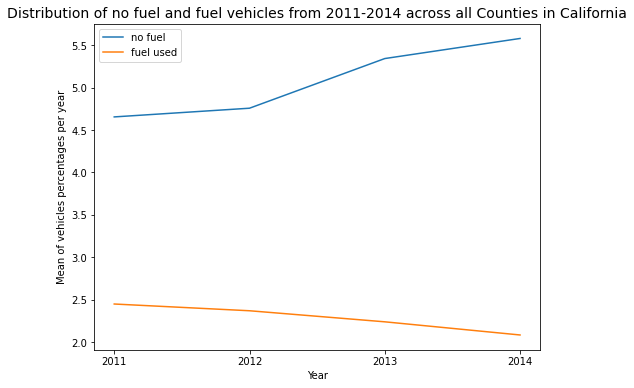

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(census_ozone['year'].unique(), no_fuel, label = "no fuel")
plt.plot(census_ozone['year'].unique(), fuel_vehicle, label = "fuel used")
plt.xticks([2011, 2012, 2013, 2014])
plt.title('Distribution of no fuel and fuel vehicles from 2011-2014 across all Counties in California', size = 14)
plt.xlabel('Year')
plt.ylabel('Mean of vehicles percentages per year')
plt.legend()
plt.show()

Overall, the number of no fuel vehicles is larger than the number of fuel vehicles. The number of no fuel vehicle increases from 2011-2012 and decreases from 2012-2014. The number of fuel vehicle decreases from 2011-2014.

### Feature Engineering

Heatmap showing the correlation between each features with the ozone.

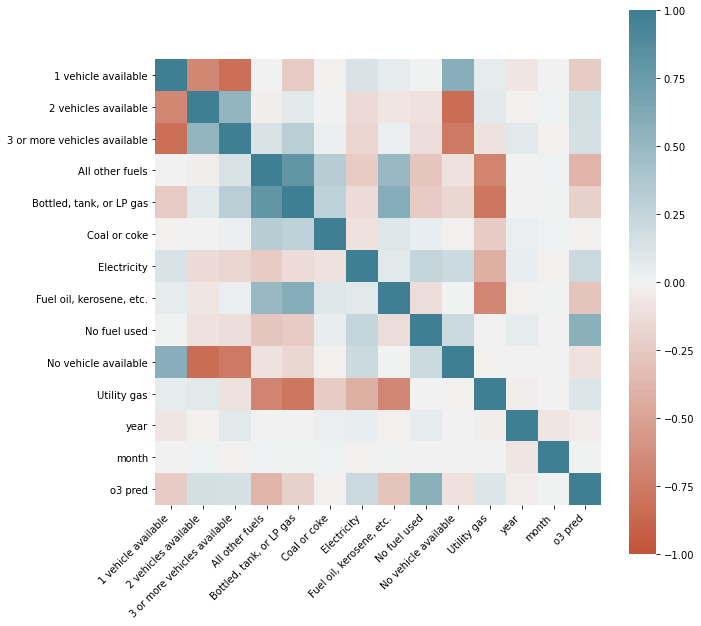

In [ ]:
features = census_ozone
corr = features.corr()
# Plot the correlation of all features using heatmap
ax = plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show();

From this heatmap, we can see that `No fuel used` has a positve correlation with `o3 pred` meanwhile `All other fuels`, `Fuel oil, kerosene, etc.`, and `Bottled, tank, or LP gas` has a negative correlation.

In [ ]:
X_features = ['No fuel used', 'All other fuels', 'Fuel oil, kerosene, etc.', 'Bottled, tank, or LP gas']

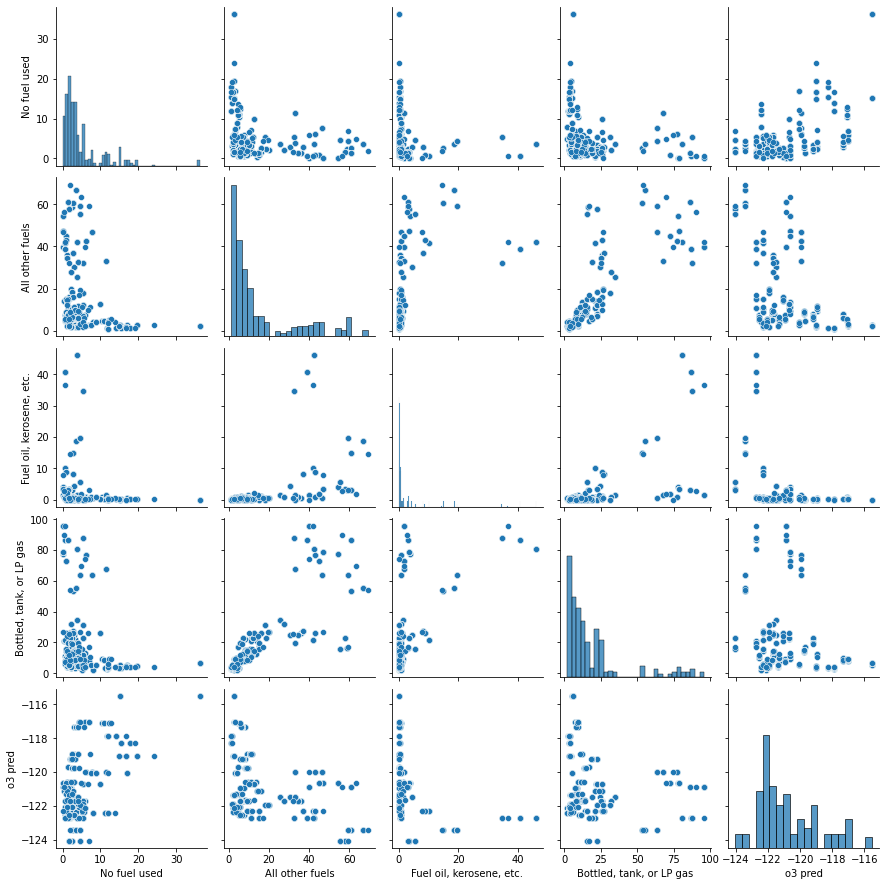

In [ ]:
ozone_features = census_ozone[ X_features + ["o3 pred"]]
sns.pairplot(ozone_features)

### Prediction Analysis

In [ ]:
# define rmse function
def rmse(y, y_hat):
    return np.sqrt(np.mean((y-y_hat)**2))

# define normalize function
def normalize(df):
    return (df - df.mean()) / df.std()

#### Step 1: Split the data into training and testing set

In this project we will try two different ways to split the data:

1. Option 1: training: data from 2011 - 2013 and testing: data for 2014
2. Option 2: Randomly assigned the training and testing set

In [ ]:
ozone_train1, ozone_test1 = ozone_features[census_ozone['year'] != 2014], ozone_features[census_ozone['year'] == 2014]
ozone_train2, ozone_test2 = train_test_split(ozone_features, test_size = 0.1, random_state = 42)

In [ ]:
# Reformat the name of the columns
def Phi(df):
    df.columns = ['no_fuel_used', 'other_fuel', 'fuel_oil_kerosene', 'bottled_tank', 'o3_pred']
    return df

Phi(ozone_train1)
Phi(ozone_train2)
Phi(ozone_test1)
Phi(ozone_test2)

,no_fuel_used,other_fuel,fuel_oil_kerosene,bottled_tank,o3_pred
129,6.2,42.8,0.9,77.0,-119.971430
247,1.2,2.3,0.2,4.7,-121.379868
453,0.6,5.4,0.2,8.1,-121.728091
223,1.4,7.3,0.0,8.0,-120.955051
415,2.3,5.3,0.3,9.1,-120.955051
...,...,...,...,...,...
123,6.2,42.8,0.9,77.0,-119.971430
141,1.7,5.1,0.4,10.0,-122.553922
98,0.6,38.8,40.8,86.7,-122.724771
46,4.2,11.6,0.0,12.4,-118.930753


#### 1. GLM

#### Option 1: Predict 2014 data based on 2013 data

##### Step 2: Build the GLM

In [ ]:
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('o3_pred ~ no_fuel_used + other_fuel + fuel_oil_kerosene + bottled_tank', ozone_train1)
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, bottled_tank, fuel_oil_kerosene, other_fuel, no_fuel_used, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.


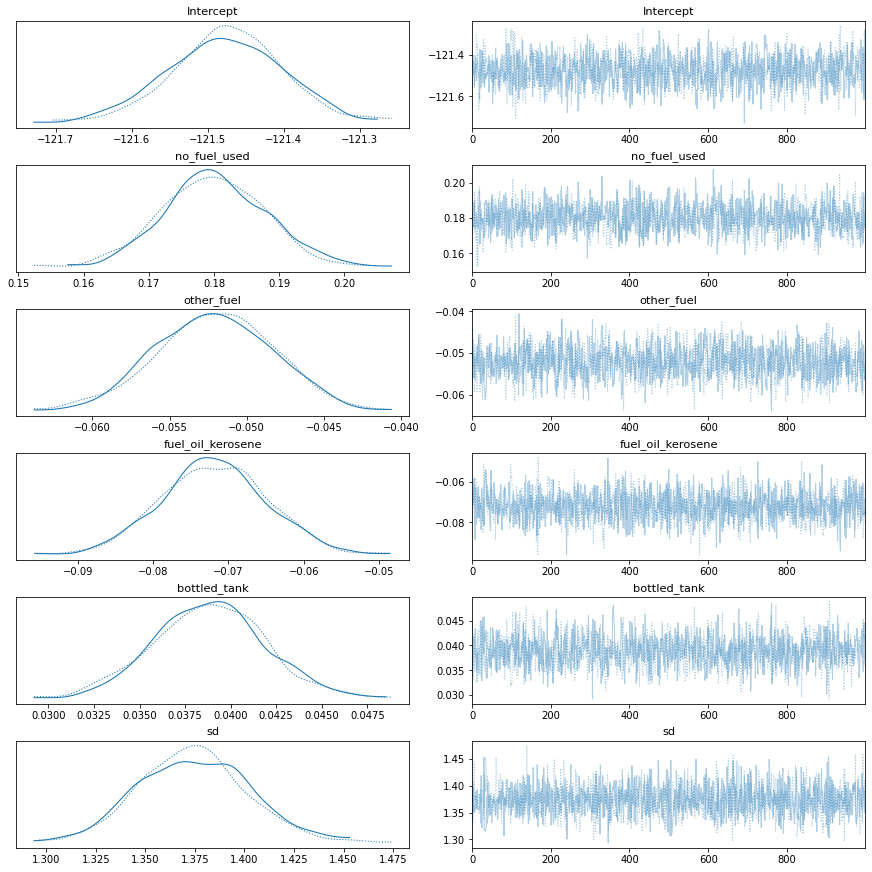

In [ ]:
arviz.plot_trace(gaussian_trace)
plt.show()

In [ ]:
pm.summary(gaussian_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-121.476,0.074,-121.609,-121.334,0.002,0.001,1249.0,1187.0,1.00
no_fuel_used,0.180,0.008,0.166,0.195,0.000,0.000,1439.0,1367.0,1.00
other_fuel,-0.052,0.004,-0.059,-0.045,0.000,0.000,1174.0,1339.0,1.00
fuel_oil_kerosene,-0.072,0.007,-0.084,-0.058,0.000,0.000,1613.0,1249.0,1.00
bottled_tank,0.039,0.003,0.033,0.045,0.000,0.000,1399.0,1273.0,1.00
sd,1.374,0.027,1.321,1.424,0.001,0.000,1694.0,872.0,1.01


Interpreting the result:

$$o3\_pred = 0.18* no\_fuel\_used - 0.052 * other\_fuel - 0.072 * fuel\_oil\_kerosene + 0.039 * bottled\_tank - 121.476 + \epsilon$$

Next, we will calculate the rmse score for the training dataset

In [ ]:
def GLM_prediction(df, intercept, no_fuel_used, other_fuel, fuel_oil_kerosene, bottled_tank):
    return intercept + no_fuel_used * df['no_fuel_used'] + other_fuel * df['other_fuel'] + fuel_oil_kerosene * df['fuel_oil_kerosene'] + bottled_tank * df['bottled_tank']
y_hat = GLM_prediction(ozone_train1, -121.476, .18, -.052, -.072, .039)
y = ozone_train1['o3_pred']
rmse(y, y_hat)

1.370749941058297

##### Step 3: Check the Testing RMSE

In [ ]:
y_hat = GLM_prediction(ozone_test2, -121.476, .18, -.052, -.072, .039)
y = ozone_test2['o3_pred']
rmse(y, y_hat)

1.4679136570076772

#### Option 2: Random assignment of testing and training

##### Step 2: Build the GLM

In [ ]:
with pm.Model() as gaussian_model:
    glm.GLM.from_formula('o3_pred ~ no_fuel_used + other_fuel + fuel_oil_kerosene + bottled_tank', ozone_train2)
    gaussian_trace = pm.sample(1000, cores=2, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, bottled_tank, fuel_oil_kerosene, other_fuel, no_fuel_used, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 82 seconds.


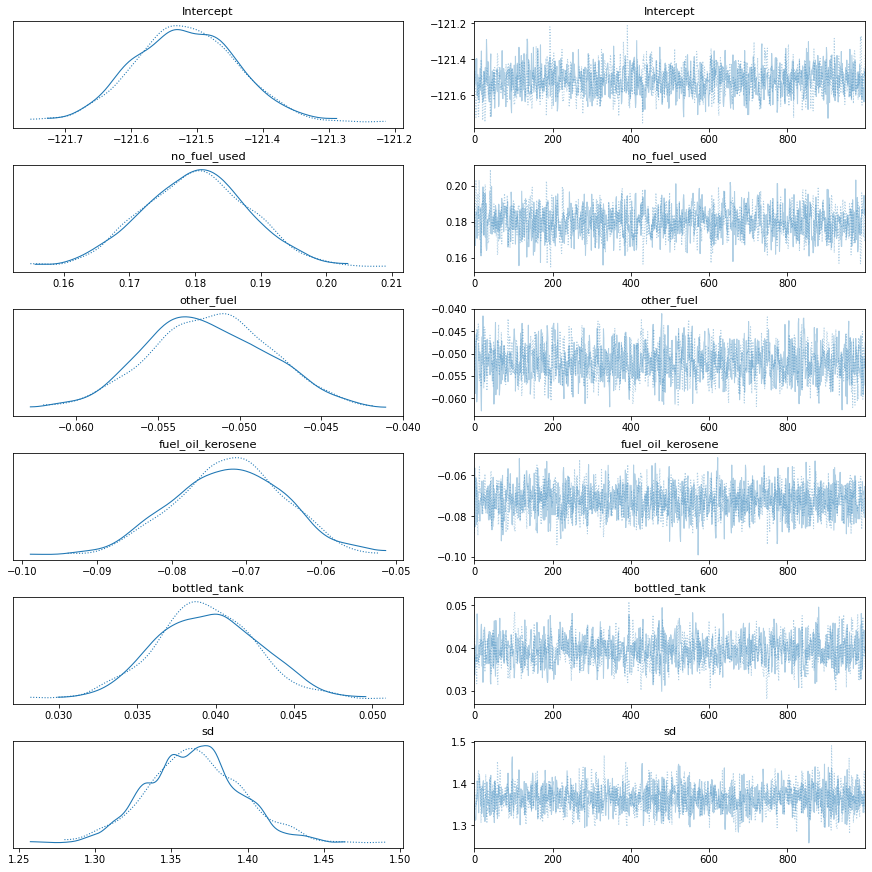

In [ ]:
arviz.plot_trace(gaussian_trace)
plt.show()

In [ ]:
pm.summary(gaussian_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-121.517,0.079,-121.662,-121.372,0.002,0.002,1311.0,1490.0,1.0
no_fuel_used,0.180,0.008,0.166,0.196,0.000,0.000,1305.0,1442.0,1.0
other_fuel,-0.052,0.004,-0.059,-0.044,0.000,0.000,1314.0,1366.0,1.0
fuel_oil_kerosene,-0.072,0.007,-0.086,-0.060,0.000,0.000,1816.0,1626.0,1.0
bottled_tank,0.039,0.003,0.033,0.045,0.000,0.000,1303.0,1358.0,1.0
sd,1.365,0.030,1.305,1.421,0.001,0.001,1643.0,1243.0,1.0


Interpreting the result:

$$o3\_pred = 0.18* no\_fuel\_used - 0.052 * other\_fuel - 0.072 * fuel\_oil\_kerosene + 0.039 * bottled\_tank - 121.517 + \epsilon$$

In [ ]:
y_hat = GLM_prediction(ozone_train2, -121.514, .18, -.052, -.072, .04)
y = GLM_Phi(ozone_train2['o3_pred'])
rmse(y, y_hat)

1.360618052642358

##### Step 3: Check the Testing RMSE

In [ ]:
y_hat = GLM_prediction(ozone_test1, -121.476, .18, -.052, -.072, .039)
y = ozone_test1['o3_pred']
rmse(y, y_hat)

1.4117780274994136

#### 2. Blackbox Model - Random Forest

#### Option 1: Predict 2014 data based on 2013 data

##### Step 2: Build the Random Forest Model

In [ ]:
X_train, y_train = ozone_train1.drop(columns = {'o3_pred'}), ozone_train1['o3_pred']
X_test, y_test = ozone_test1.drop(columns = {'o3_pred'}), ozone_test1['o3_pred']

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(max_features = 1/3)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.3333333333333333)

Calculate the accuracy and rmse of the training data

In [ ]:
rf_train_accuracy = random_forest_model.score(X_train, y_train)
rf_train_accuracy

0.9999997492597723

In [ ]:
y_train_pred = random_forest_model.predict(X_train)
rf_train_rmse = rmse(y_train_pred, y_train)

rf_train_rmse

0.000948495309663528

##### Step 3: Check the Testing Accuracy

In [ ]:
rf_test_accuracy = random_forest_model.score(X_test, y_test)
rf_test_accuracy

0.6500099539471296

In [ ]:
y_test_pred = random_forest_model.predict(X_test)
rf_test_rmse = rmse(y_test_pred, y_test)
rf_test_rmse

1.0423987206673655

#### Option 2: Random assignment of testing and training

##### Step 2: Build the Random Forest Model

In [ ]:
X_train, y_train = ozone_train2.drop(columns = {'o3_pred'}), ozone_train2['o3_pred']
X_test, y_test = ozone_test2.drop(columns = {'o3_pred'}), ozone_test2['o3_pred']
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.3333333333333333)

Calculate the accuracy and rmse of the training data

In [ ]:
rf_train_accuracy = random_forest_model.score(X_train, y_train)
rf_train_accuracy

0.9985055771731259

In [ ]:
y_train_pred = random_forest_model.predict(X_train)
rf_train_rmse = rmse(y_train_pred, y_train)

rf_train_rmse

0.07267227775990198

##### Step 3: Check the Testing Accuracy

In [ ]:
rf_test_accuracy = random_forest_model.score(X_test, y_test)
rf_test_accuracy

0.9996970623007192

In [ ]:
y_test_pred = random_forest_model.predict(X_test)
rf_test_rmse = rmse(y_test_pred, y_test)
rf_test_rmse

0.03426306139555263

# Instrumental Variable

Is there a causal relationship between COVID-19 pandemic and pollution (PM2.5) levels?

## EDA

### Data Cleaning:

Because we are focused on California county data, we needed to filter the data sets to ensure the same level of granularity. For instance, we filtered for California counties for the US pollution (PM 2.5) data. We then merged them together and grouped them by date and county to do our EDA.

In [ ]:
#Clean Covid 
def clean_covid(df, state):
    return df[df['state'] == state]

covid_CA = clean_covid(us_counties_covid, "California")

# Clean Weather 
def clean_weather(data, stations): 
    data1 = data.iloc[:, [0,1,5,15,21,25]]
    data1.columns = ['st_id', 'date','precipitation', 'avg_temp','avg_rel_humidity', 'avg_wind_speed']
    data1 = data1.rename(columns ={'st_id': 'Station Number'})
    stations = stations[["Station Number", "Name", "County"]]
    final = pd.merge(left = data1, right = stations, on = "Station Number", how = "left")
    final = final[final['Station Number'] <= 261]
    final = final[~(final == '--').any(axis=1)]
    final['precipitation'] = final['precipitation'].astype(float)
    final['avg_temp'] = final['avg_temp'].astype(float)
    final['avg_rel_humidity'] = final['avg_rel_humidity'].astype(float)
    final['avg_wind_speed'] = final['avg_wind_speed'].astype(float)
    return final

# Clean Pollution 
def clean_pollution(df):
    return df[['Date', 'DAILY_AQI_VALUE', 'COUNTY']]

cleaned_o20 = clean_pollution(ozone_2020)
cleaned_o21 = clean_pollution(ozone_2021)
cleaned_p20 = clean_pollution(pm25_2020)
cleaned_p21 = clean_pollution(pm25_2021) 
cleaned_p21 = clean_pollution(pm25_2021) 

cleaned_w20 = clean_weather(weatherCA2020, stations)
cleaned_w21 = clean_weather(weatherCA2021, stations)

In [ ]:
#Merging 2020 & 2021 data 
def merge_data(data1, data2, datatype):
    data3 = pd.DataFrame(np.concatenate((data1, data2), axis = 0))
    if datatype == 'w': 
        data3.iloc[:,1] = [x.strftime('%Y-%m-%d') for x in pd.to_datetime(data3.iloc[:,1])]
        names = ['st_id', 'date','precipitation', 'avg_temp','avg_rel_humidity', 'avg_wind_speed', "Name", "County"]
        data3.columns = names
    else: 
        data3.iloc[:,0] = [x.strftime('%Y-%m-%d') for x in pd.to_datetime(data3.iloc[:,0])]
        data3['Month'] = data3[0].str[5:7]
        data3['Year'] = data3[0].str[0:4]
        data3.columns = ['date', 'DAILY_AQI_VALUE', 'County', 'Month', 'Year']
    return data3
    
merged_p = merge_data(cleaned_p20,cleaned_p21, 'p')
merged_o = merge_data(cleaned_o20,cleaned_o21, 'o')
merged_w = merge_data(cleaned_w20,cleaned_w21, 'w')

In [ ]:
#Average columns in merged year datasets by County (one estimate per County per day)
def clean_merged(name, agg):
    if (name == "p"):
        df = merged_p
        df['DAILY_AQI_VALUE'] = df['DAILY_AQI_VALUE'].astype(float)
    elif (name == "o"):
        df = merged_o
        df['DAILY_AQI_VALUE'] = df['DAILY_AQI_VALUE'].astype(float) 
    else: 
        df = merged_w
        df['precipitation'] = df['precipitation'].astype(float)
        df['avg_temp'] = df['avg_temp'].astype(float)
        df['avg_rel_humidity'] = df['avg_rel_humidity'].astype(float)
        df['avg_wind_speed'] = df['avg_wind_speed'].astype(float)
    
    df['Year'] = df['date'].str[0:4]
    df['Month'] = df['date'].str[5:7]
    df['Day'] = df['date'].str[8:]

    if agg == "mean":
        return df.groupby(['County', 'date'], as_index=False).mean()
    else:
        return df.groupby(['County', 'date'], as_index=False).sum()

county_day_p = clean_merged("p", "mean")
county_day_o = clean_merged("o", "mean")
county_day_w = clean_merged("w", "mean")

### Total Cases of COVID-19 in California

In [ ]:
#Adding year and month to the covid data set
covid_CA['Year'] = covid_CA['date'].str[:4]
covid_CA['Month'] = covid_CA['date'].str[5:7]

#Merging all the pollution and covid data set together and taking the average of each month
combined_plot1 = merged_p.merge(covid_CA, on=['date'])
combined_plot1.drop(columns={'Year_y', 'Month_y'}, inplace=True)
combined_plot1.rename(columns={'Month_x': 'Month', 'Year_x': 'Year', 'County':'county', 'Day':'day'}, inplace=True)
combined_plot1 = combined_plot1.groupby(['Year', 'Month']).agg(np.mean)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
No handles with labels found to put in legend.


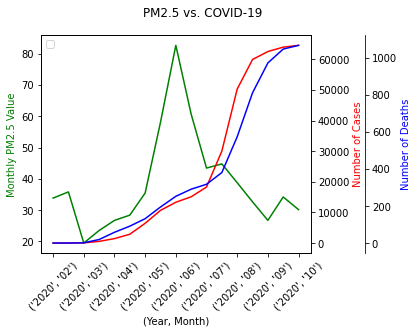

In [ ]:
#Plotting line plots
fig1, ax1 = plt.subplots()
axes = [ax1, ax1.twinx(), ax1.twinx()]
fig1.subplots_adjust(right=0.75)
axes[-1].spines['right'].set_position(('axes', 1.2))
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

axes[0].plot(combined_plot1['DAILY_AQI_VALUE'].to_numpy(), color='g')
axes[1].plot(combined_plot1['cases'].to_numpy(), color='r')
axes[2].plot(combined_plot1['deaths'].to_numpy(), color='b')

axes[0].set_ylabel("Monthly PM2.5 Value", color='g')
axes[1].set_ylabel("Number of Cases", color='r')
axes[2].set_ylabel("Number of Deaths", color='b')

axes[0].set_xticklabels(list(combined_plot1.reset_index().groupby(['Year', 'Month']).groups.keys()), rotation=45)
axes[0].set_xlabel('(Year, Month)')
plt.suptitle('PM2.5 vs. COVID-19')
plt.legend()
plt.show()

**Heatmap with PM 2.5, ozone, and the weather columns (not date & county)**

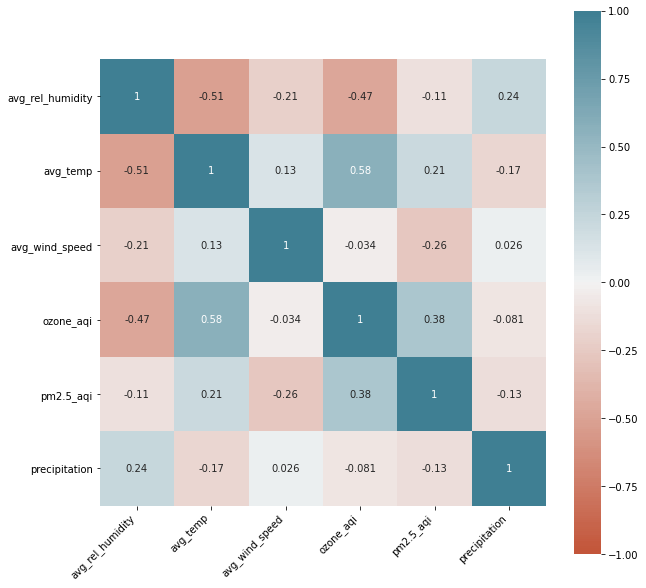

In [ ]:
merged_together = county_day_o.merge(county_day_p, on = ['County', 'date']).merge(county_day_w, on = ['County', 'date'])
merged_together.rename(columns = {'DAILY_AQI_VALUE_x': 'ozone_aqi', 'DAILY_AQI_VALUE_y': 'pm2.5_aqi'}, inplace=True)
merged_together_norm = normalize(merged_together)
corr2 = merged_together_norm.corr()

# Plot the correlation of all features using heatmap
ax2 = plt.figure(figsize=(10,10))
ax2 = sns.heatmap(
    corr2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),

    square=True,
    annot=True
)
ax2.set_xticklabels(
    ax2.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show();

## Instrumental Variable Code

In [ ]:
#Merge dataset for IV Analysis 
def IV_dataset(Z_data, X_data, Y_data, Z): 
    ivdata1 = pd.merge(X_data, Z_data, how = 'left', left_on= ['date', 'County'], right_on = ['date', 'County'])
    ivdata1 = ivdata1[['date', 'DAILY_AQI_VALUE', 'County', Z]]
    ivdata1 = ivdata1[~ivdata1[Z].isna()]
    ivdata2 = pd.merge(Y_data, ivdata1, how = 'left', left_on= ['date', 'county'], right_on = ['date','County'])
    completed = pd.DataFrame(ivdata2[~ivdata2[Z].isna()])
    completed = completed[['date', 'county', 'cases', 'deaths', 'DAILY_AQI_VALUE', Z]]
    return completed

#Fits OLS Model 
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    target = np.array(df[target_variable])
    inputs = np.array(df[explanatory_variables])
    if intercept:
        inputs = sm.add_constant(inputs)
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

#Fits OLS parameters to predict Pollution from Weather
def first_stage(pollution_data, Z): 
    completed = IV_dataset(county_day_w, pollution_data , covid_CA, Z)
    stage_1 = fit_OLS_model(completed, 'DAILY_AQI_VALUE', Z, intercept=True) 
    return stage_1

#Predict number of Covid Cases from the predicted amount of Pollution 
def second_stage(pollution_data, Z):
    stage1 = first_stage(pollution_data, Z)
    intercept_OLS = stage1.params[0]
    gamma1_OLS = stage1.params[1]
    completed = IV_dataset(county_day_w, pollution_data, covid_CA, Z)
    X_1_hat = intercept_OLS + gamma1_OLS*completed[Z]
    completed["Predicted Pollution"] = X_1_hat
    stage_2 = fit_OLS_model(completed, 'cases', 'Predicted Pollution', intercept = True) 
    return stage_2


## Estimating Effects of PM 2.5 on Covid Cases via Average Wind Speed (California 2020-2021)

In [ ]:
#Predict PM 2.5 Pollution from Average Temperature 
stage1_p = first_stage(county_day_p, 'avg_wind_speed')
print(stage1_p.summary(yname = 'Predicted PM 2.5 Pollution', xname = ['const', 'Average Wind Speed']))

                                OLS Regression Results                                
Dep. Variable:     Predicted PM 2.5 Pollution   R-squared:                       0.069
Model:                                    OLS   Adj. R-squared:                  0.069
Method:                         Least Squares   F-statistic:                     841.1
Date:                        Sat, 08 May 2021   Prob (F-statistic):          1.95e-178
Time:                                18:31:31   Log-Likelihood:                -55178.
No. Observations:                       11289   AIC:                         1.104e+05
Df Residuals:                           11287   BIC:                         1.104e+05
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [ ]:
#Estimate Number of Covid Cases from predicted PM 2.5 Pollution
stage2_p = second_stage(county_day_p, 'avg_wind_speed')
print(stage2_p.summary(yname = 'Covid Cases', xname = ['const', 'Predicted PM 2.5 Pollution']))

                            OLS Regression Results                            
Dep. Variable:            Covid Cases   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     76.82
Date:                Sat, 08 May 2021   Prob (F-statistic):           2.14e-18
Time:                        18:31:33   Log-Likelihood:            -1.3929e+05
No. Observations:               11289   AIC:                         2.786e+05
Df Residuals:                   11287   BIC:                         2.786e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Estimating Effects of Ozone on Covid Cases via Average Temperature (California 2020-2021)

In [ ]:
#Predict PM 2.5 Pollution from Average Temperature 
stage1_o = first_stage(county_day_o, 'avg_temp')
print(stage1_o.summary(yname = 'Predicted Ozone Pollution', xname = ['const', 'Average Temperature']))

                                OLS Regression Results                               
Dep. Variable:     Predicted Ozone Pollution   R-squared:                       0.311
Model:                                   OLS   Adj. R-squared:                  0.311
Method:                        Least Squares   F-statistic:                     5544.
Date:                       Sat, 08 May 2021   Prob (F-statistic):               0.00
Time:                               18:31:35   Log-Likelihood:                -52596.
No. Observations:                      12298   AIC:                         1.052e+05
Df Residuals:                          12296   BIC:                         1.052e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [ ]:
stage2_o = second_stage(county_day_o, 'avg_temp')
print(stage2_o.summary(yname = 'Covid Cases', xname = ['const', 'Predicted Ozone Pollution']))

                            OLS Regression Results                            
Dep. Variable:            Covid Cases   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     39.40
Date:                Sat, 08 May 2021   Prob (F-statistic):           3.56e-10
Time:                        18:31:38   Log-Likelihood:            -1.5128e+05
No. Observations:               12298   AIC:                         3.026e+05
Df Residuals:                   12296   BIC:                         3.026e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Text(0, 0.5, 'Residual')

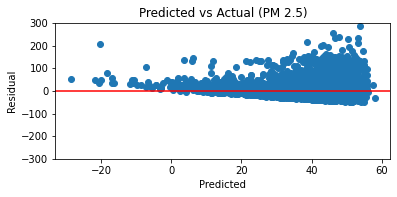

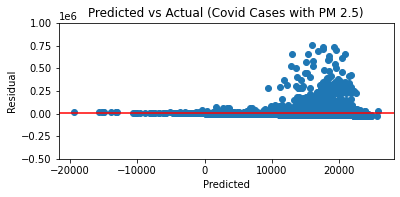

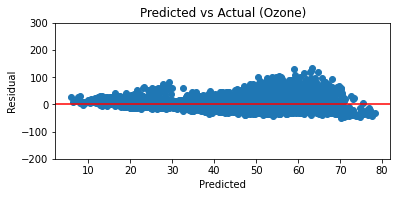

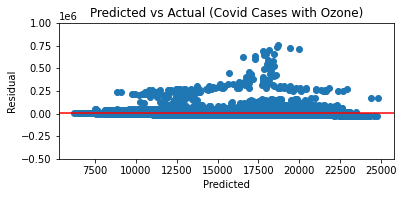

In [ ]:
#Residual Plot of Stage 1 for PM 
pred_val = stage1_p.fittedvalues.copy()
completed = IV_dataset(county_day_w, county_day_p,covid_CA, 'avg_wind_speed')
true_val = completed['DAILY_AQI_VALUE'].values.copy()
residual = (true_val - pred_val)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val, residual)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(-300, 300)
plt.title("Predicted vs Actual (PM 2.5)")
plt.xlabel("Predicted")
plt.ylabel("Residual")

#Residual Plot of Stage 2 for PM 
pred_val2 = stage2_p.fittedvalues.copy()
completed2 = IV_dataset(county_day_w, county_day_p,covid_CA, 'avg_wind_speed')
true_val2 = completed2['cases'].values.copy()
residual2 = (true_val2 - pred_val2)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val2, residual2)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(-500000, 1000000)
plt.title("Predicted vs Actual (Covid Cases with PM 2.5)")
plt.xlabel("Predicted")
plt.ylabel("Residual")

#Residual Plot of Stage 1 for Ozone 
pred_val3 = stage1_o.fittedvalues.copy()
completed3 = IV_dataset(county_day_w, county_day_o,covid_CA, 'avg_temp')
true_val3 = completed3['DAILY_AQI_VALUE'].values.copy()
residual3 = (true_val3 - pred_val3)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val3,residual3)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(-200, 300)
plt.title("Predicted vs Actual (Ozone)")
plt.xlabel("Predicted")
plt.ylabel("Residual")

#Residual Plot of Stage 2 for Ozone
pred_val4 = stage2_o.fittedvalues.copy()
completed4 = IV_dataset(county_day_w, county_day_o,covid_CA, 'avg_temp')
true_val4 = completed4['cases'].values.copy()
residual4 = (true_val4 - pred_val4)
fig, ax = plt.subplots(figsize=(6,2.5))
ax.scatter(pred_val4, residual4)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylim(-500000, 1000000)
plt.title("Predicted vs Actual (Covid Cases with Ozone)")
plt.xlabel("Predicted")
plt.ylabel("Residual")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6118d04c-bc17-4369-98ae-6e705e155445' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>